In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from preprocess import make_dataset, scale_IR
import torch.optim as optim
from model import *
from torch.utils.data import Dataset, DataLoader


In [2]:
class CustomDataset(Dataset):
    def __init__(self, IR_dataset, distance_dataset, ground_truth, filename_dataset):
        self.IR_dataset = IR_dataset
        self.distance_dataset = distance_dataset
        self.ground_truth = ground_truth
        self.filename_dataset = filename_dataset

    def __len__(self):
        return len(self.IR_dataset)

    def __getitem__(self, idx):
        IR_data = self.IR_dataset[idx]
        distance_data = self.distance_dataset[idx]
        label = self.ground_truth[idx]
        # 将标签转换为one-hot编码
        label_one_hot = torch.zeros(LABEL_NUM)
        label_one_hot[label] = 1
        return IR_data, distance_data, label_one_hot, self.filename_dataset[idx]


In [4]:
sampled_distance_dataset, sampled_IR_dataset, groudtruth, sampled_filename_dataset = make_dataset()
# 示例数据转换
distance_tensor = torch.tensor(np.stack(sampled_distance_dataset, axis=0), dtype=torch.float32)
IR_tensor, max_IR, min_IR = scale_IR(np.stack(sampled_IR_dataset, axis=0))


distance length is 235
IR length is 235
gt length is 235
Distance dataset 1: 1626, (14, 1)
IR dataset 1: 1626, (9, 64)
gt dataset 1: 1626
filename dataset 1: 1626
Distance dataset 2: 1626, (14, 1)
IR dataset 2: 1626, (9, 64)
gt dataset 2: 1626
filename dataset 2: 1626


In [5]:

# 创建数据集和数据加载器
dataset = CustomDataset(IR_tensor, distance_tensor, groudtruth, sampled_filename_dataset)
# dataloader = DataLoader(dataset, batch_size=BATCH, shuffle=True)


In [6]:
from torch.utils.data import random_split

# 随机分割训练集和测试集，假设80%为训练集，20%为测试集
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 创建数据加载器
train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)


In [7]:

# 实例化网络
net = MyMLP().to(mydevice)
# net = MyCNN().to(mydevice)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [8]:
loss_history = []
# 训练循环示例
for epoch in range(800):
    running_loss = 0.0
    for i, (IR_data, distance_data, labels, _) in enumerate(train_dataloader, 0):
        IR_data = IR_data.to(mydevice)
        distance_data = distance_data.to(mydevice)
        labels = labels.to(mydevice)
        # 清零梯度
        optimizer.zero_grad()

        # 前向传播
        outputs = net(IR_data, distance_data)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新权重
        optimizer.step()

        # 打印统计信息
        running_loss += loss.cpu().item()
        if i % 20 == 19:  # 每10个批次打印一次
            loss_mean = running_loss / 20
            loss_history.append(loss_mean)
            print(f"[{epoch + 1}, {i + 1}] loss: {loss_mean:.3f}")
            running_loss = 0.0


[1, 20] loss: 1.609
[1, 40] loss: 1.575
[1, 60] loss: 1.535
[2, 20] loss: 1.514
[2, 40] loss: 1.478
[2, 60] loss: 1.529
[3, 20] loss: 1.510
[3, 40] loss: 1.502
[3, 60] loss: 1.478
[4, 20] loss: 1.495
[4, 40] loss: 1.479
[4, 60] loss: 1.476
[5, 20] loss: 1.470
[5, 40] loss: 1.476
[5, 60] loss: 1.442
[6, 20] loss: 1.419
[6, 40] loss: 1.440
[6, 60] loss: 1.408
[7, 20] loss: 1.423
[7, 40] loss: 1.394
[7, 60] loss: 1.358
[8, 20] loss: 1.370
[8, 40] loss: 1.356
[8, 60] loss: 1.349
[9, 20] loss: 1.339
[9, 40] loss: 1.334
[9, 60] loss: 1.336
[10, 20] loss: 1.337
[10, 40] loss: 1.296
[10, 60] loss: 1.319
[11, 20] loss: 1.316
[11, 40] loss: 1.293
[11, 60] loss: 1.311
[12, 20] loss: 1.313
[12, 40] loss: 1.321
[12, 60] loss: 1.271
[13, 20] loss: 1.280
[13, 40] loss: 1.306
[13, 60] loss: 1.284
[14, 20] loss: 1.266
[14, 40] loss: 1.314
[14, 60] loss: 1.293
[15, 20] loss: 1.288
[15, 40] loss: 1.300
[15, 60] loss: 1.273
[16, 20] loss: 1.297
[16, 40] loss: 1.285
[16, 60] loss: 1.282
[17, 20] loss: 1.30

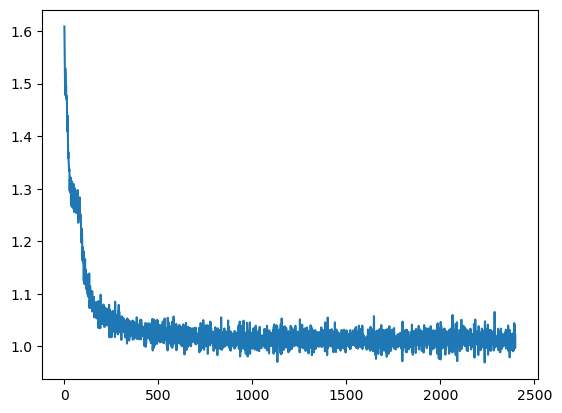

In [9]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.show()

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 测试循环
true_labels = []
predicted_labels = []
filenames = []
with torch.no_grad():
    for i, (IR_data, distance_data, labels, filename) in enumerate(test_dataloader):
        IR_data = IR_data.to(mydevice)
        distance_data = distance_data.to(mydevice)

        outputs = net(IR_data, distance_data)
        outputs = outputs.cpu()

        _, predicted = torch.max(outputs.data, 1)
        _, gt = torch.max(labels.data, 1)
        
        true_labels.extend(gt.numpy())
        predicted_labels.extend(predicted.numpy())
        filenames += filename

# 计算性能指标
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1) # macro
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}\n")

# 计算每个类别的精确度和召回率
precision_per_class = precision_score(true_labels, predicted_labels, average=None, zero_division=0)
recall_per_class = recall_score(true_labels, predicted_labels, average=None, zero_division=0)

# 打印结果
print("labels are ", ['idle', 'sit', 'sit2stand', 'stand', 'stand2sit'])
print(f"Precision per class: {precision_per_class}")
print(f"Recall per class: {recall_per_class}\n")

from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predicted_labels)

print("混淆矩阵:")
print(cm)

Accuracy: 0.8466
Precision: 0.8256
Recall: 0.8466

labels are  ['idle', 'sit', 'sit2stand', 'stand', 'stand2sit']
Precision per class: [0.6        0.93495935 0.8        0.78571429 0.82352941]
Recall per class: [0.08108108 0.96638655 0.8        0.95652174 0.97674419]

混淆矩阵:
[[  3   5   7  13   9]
 [  0 115   0   4   0]
 [  1   0  28   6   0]
 [  1   3   0  88   0]
 [  0   0   0   1  42]]


In [11]:
# 找出被错误分类的样本
misclassified_samples = [filenames[i] for i in range(len(filenames)) if true_labels[i] != predicted_labels[i]]
print("被错误分类的样本:", misclassified_samples)

被错误分类的样本: ['offset_2|high-position-sit_1712645977', 'offset_2|high-position-nobody_1712646240', 'offset_-1|high-position-sit2stand_1712650178', 'offset_1|high-position-nobody_1712652324', 'offset_-3|high-position-nobody_1712647746', 'offset_3|high-position-nobody_1712646254', 'offset_-3|high-position-nobody_1712644633', 'high-position-sit2stand_1712646130', 'offset_-3|high-position-nobody_1712646240', 'offset_2|high-position-stand_1712644458', 'offset_2|high-position-nobody_1712650381', 'offset_-3|high-position-nobody_1712652332', 'offset_2|high-position-nobody_1712651414', 'offset_-2|high-position-nobody_1712650361', 'offset_-3|high-position-nobody_1712650390', 'offset_3|high-position-nobody_1712644617', 'offset_1|high-position-nobody_1712650371', 'offset_-2|high-position-stand_1712644479', 'offset_3|high-position-nobody_1712644633', 'offset_3|high-position-sit2stand_1712651291', 'offset_-2|high-position-nobody_1712647746', 'offset_3|high-position-sit2stand_1712645440', 'offset_3|high

In [14]:
import shutil
import os
from datetime import datetime
from pathlib import Path

# 创建目标文件夹
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
target_folder = os.path.join("wrongs", timestamp)
os.makedirs(target_folder, exist_ok=True)

# 复制被错误分类的样本到目标文件夹
for filename in misclassified_samples:
    # 假设原始文件位于当前文件夹中
    if '|' in filename:
        real_filename = filename.split('|')[1] 
    source_path = Path('..') / 'data_v2' / real_filename.split('_')[0] / f'{real_filename}.mp4'
    # target_path = os.path.join(target_folder, os.path.basename(filename))
    shutil.copy(source_path, target_folder)

print(f"被错误分类的样本已复制到 {target_folder}")


FileNotFoundError: [Errno 2] No such file or directory: '../data_v2/high-position-sit/high-position-sit_1712645977.mp4'

In [ ]:
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")

Total parameters: 3165


In [14]:
torch.save(net.state_dict(), 'checkpoints/high/F9-14-MLP221-Fea4-24-gap32-miniFilter-0d92.pth')